In [17]:
using ITensors 
using Measurements
using Plots

In [8]:
function GN_Wilson(L,m₀,g₀²,r,χ,sw)
    l = L-2
    aₗ = 1/(L-1)
    aₛ = 1/(l-1)
    sites = siteinds("Fermion",L)
    ampoₗ = OpSum()
    ampoₛ = OpSum()
    for j in 2:2:L-2
        ampoₗ += (1im/2aₗ), "C",j,"Cdag",j+2
        ampoₗ += (-1im/2aₗ), "C",j+2,"Cdag",j
    end
    for j in 1:2:L-2
        ampoₗ += (-1im/2aₗ), "C",j,"Cdag",j+2
        ampoₗ += (1im/2aₗ), "C",j+2,"Cdag",j
    end
    for j in 1:L-1
        ampoₗ += (-1im*m₀), "Cdag",j,"Cdag",j+1
        ampoₗ += (+1im*m₀), "C",j+1,"C",j
    end
    for j in 1:L-1
        ampoₗ += (-g₀²/2aₗ), "C * Cdag",j,"Cdag * C",j+1
        ampoₗ += (-g₀²/2aₗ), "Cdag * C",j,"C * Cdag",j+1
    end
    for j in 2:2:L-1
        ampoₗ += (+1im*r/2aₗ), "C",j,"Cdag",j+1
        ampoₗ += (-1im*r/2aₗ), "C",j+1,"Cdag",j
    end
    for j in 1:2:L-3
        ampoₗ += (+1im*r/2aₗ), "Cdag",j,"C",j+3
        ampoₗ += (-1im*r/2aₗ), "Cdag",j+3,"C",j
    end
    for j in 1:2:L-1
        ampoₗ += (-1im*r/aₗ), "Cdag",j,"C",j+1
        ampoₗ += (+1im*r/aₗ), "Cdag",j+1,"C",j
    end
    ψₗ₀ = randomMPS(sites,100)
    Hₗ = MPO(ampoₗ,sites)
    ####################################################
    # small lattice
    for j in 2:2:l-2
        ampoₛ += (+1im/2aₛ), "C",j,"Cdag",j+2
        ampoₛ += (-1im/2aₛ), "C",j+2,"Cdag",j
    end
    for j in 1:2:l-2
        ampoₛ += (-1im/2aₛ), "C",j,"Cdag",j+2
        ampoₛ += (+1im/2aₛ), "C",j+2,"Cdag",j
    end
    for j in 1:l-1
        ampoₛ += (-1im*m₀), "Cdag",j,"Cdag",j+1
        ampoₛ += (+1im*m₀), "C",j+1,"C",j
    end
    for j in 1:l-1
        ampoₛ += (-g₀²/2aₛ), "C * Cdag",j,"Cdag * C",j+1
        ampoₛ += (-g₀²/2aₛ), "Cdag * C",j,"C * Cdag",j+1
    end
    for j in 2:2:l-1
        ampoₛ += (+1im*r/2aₛ), "C",j,"Cdag",j+1
        ampoₛ += (-1im*r/2aₛ), "C",j+1,"Cdag",j
    end
    for j in 1:2:l-3
        ampoₛ += (+1im*r/2aₛ), "Cdag",j,"C",j+3
        ampoₛ += (-1im*r/2aₛ), "Cdag",j+3,"C",j
    end
    for j in 1:2:l-1
        ampoₛ += (-1im*r/aₛ), "Cdag",j,"C",j+1
        ampoₛ += (+1im*r/aₛ), "Cdag",j+1,"C",j
    end
    ψₛ₀ = randomMPS(sites[1:l],100)
    Hₛ = MPO(ampoₛ, sites[1:l])
    
    sweep = Sweeps(sw)
    setmaxdim!(sweep, repeat([χ],sw)...)
    setcutoff!(sweep,1E-8)
    
    eₗ, ψₗ = dmrg(Hₗ, ψₗ₀, sweep, outputlevel=1)
    eₛ, ψₛ = dmrg(Hₛ, ψₛ₀, sweep, outputlevel=1)
    
    nrm = norm(inner(Hₛ,ψₛ,Hₛ,ψₛ) - inner(ψₛ', Hₛ, ψₛ)^2)/norm(inner(ψₛ',Hₛ,ψₛ))
    
    v1 = ITensor(sites[l+1])
    for j in 1:size(v1)[1]
        v1[j] = 1/sqrt(2)
    end
    v2 = ITensor(sites[L])
    for j in 1:size(v2)[1]
        v2[j] = 1/sqrt(2)
    end
    v = ITensor(1.0)
    for j in 1:l
        v = v*dag(ψₛ[j])*ψₗ[j]
    end
    v = v*v1*ψₗ[l+1]
    v = v*v2*ψₗ[L]
    return inner(v,v), norm(v), nrm
end

GN_Wilson (generic function with 1 method)

In [44]:
result_inner, result_norm, result_error = nothing, nothing, nothing
result_inner2, result_norm2, result_error2 = nothing, nothing, nothing
error_bar = nothing

In [45]:
# L::Integer, N::Integer,G²::Float64,m::Float64,sw::Integer
result_inner = Vector{ComplexF64}();
result_norm = Vector{ComplexF64}();
result_error = Vector{ComplexF64}();

In [46]:
# function GN_Wilson(L,m₀,g₀²,r,χ,sw)
for j in 4:20
    println(j)
    nnr , nrm, err = GN_Wilson(j,0.4,1.0,0.7,700,3); # change BD --> 100
#     push!(result_inner, nnr);
#     push!(result_norm, nrm);
#     push!(result_error, err);
# end
    if err < 1e-6
        push!(result_inner, nnr);
        push!(result_norm, nrm);
        push!(result_error, err);
    else
        nnr , nrm, err = GN_Wilson(j,0.4,1.0,0.7,700,3); # change BD --> 100
        push!(result_inner, nnr);
        push!(result_norm, nrm);
        push!(result_error, err);
    end
end

4
After sweep 1 energy=-8.980628675341094  maxlinkdim=4 maxerr=3.30E-16 time=0.004
After sweep 2 energy=-8.980628692799266  maxlinkdim=4 maxerr=3.69E-16 time=0.005
After sweep 3 energy=-8.980628692799264  maxlinkdim=4 maxerr=1.78E-16 time=0.008
After sweep 1 energy=-1.1999862920541953  maxlinkdim=2 maxerr=0.00E+00 time=0.002
After sweep 2 energy=-1.199999999951939  maxlinkdim=2 maxerr=0.00E+00 time=0.002
After sweep 3 energy=-1.1999999999999993  maxlinkdim=2 maxerr=0.00E+00 time=0.002
5
After sweep 1 energy=-13.734274736996293  maxlinkdim=4 maxerr=1.83E-16 time=0.011
After sweep 2 energy=-13.734276065909173  maxlinkdim=4 maxerr=1.43E-16 time=0.013
After sweep 3 energy=-13.734276065909391  maxlinkdim=4 maxerr=2.89E-17 time=0.011
After sweep 1 energy=-3.3415727707503597  maxlinkdim=2 maxerr=3.00E-17 time=0.005
After sweep 2 energy=-3.341572770751628  maxlinkdim=2 maxerr=9.62E-18 time=0.009
After sweep 3 energy=-3.3415727707516294  maxlinkdim=2 maxerr=1.33E-17 time=0.004
6
After sweep 1 e

After sweep 2 energy=-170.77985614851914  maxlinkdim=25 maxerr=9.77E-09 time=0.073
After sweep 3 energy=-170.77985616304227  maxlinkdim=25 maxerr=9.66E-09 time=0.068
After sweep 1 energy=-223.24177488305122  maxlinkdim=46 maxerr=9.67E-09 time=0.769
After sweep 2 energy=-223.24185745162816  maxlinkdim=26 maxerr=9.93E-09 time=0.100
After sweep 3 energy=-223.24185746440028  maxlinkdim=26 maxerr=9.36E-09 time=0.088
After sweep 1 energy=-170.7798328352103  maxlinkdim=33 maxerr=9.94E-09 time=0.329
After sweep 2 energy=-170.77985628337473  maxlinkdim=25 maxerr=9.76E-09 time=0.076
After sweep 3 energy=-170.77985581114956  maxlinkdim=25 maxerr=9.99E-09 time=0.109
18
After sweep 1 energy=-259.47195710273303  maxlinkdim=75 maxerr=9.92E-09 time=1.422
After sweep 2 energy=-259.4722581430758  maxlinkdim=24 maxerr=9.74E-09 time=0.118
After sweep 3 energy=-259.47225814197867  maxlinkdim=24 maxerr=9.74E-09 time=0.092
After sweep 1 energy=-202.6340625146484  maxlinkdim=37 maxerr=9.82E-09 time=0.468
Afte

In [47]:
site_number = [x for x in 1:length(result_inner)];
result_inner2 = real(result_inner);
result_norm2 = real(result_norm);
result_error2 = real(result_error);

In [48]:
error_bar = [sqrt(x) for x in result_error2[1:end]];

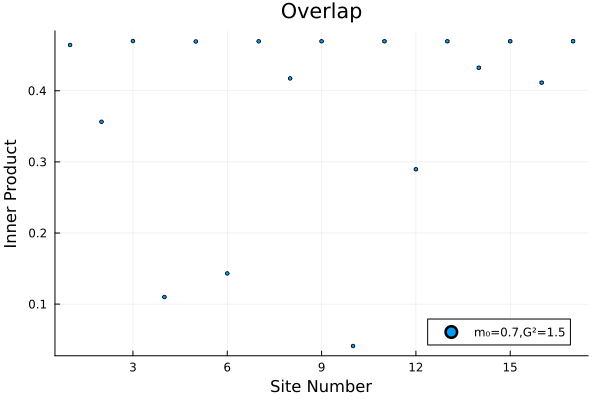

In [49]:
scatter(site_number, 
    result_norm2.± error_bar, 
#     xlim=(0,25),xticks=((0:2:27)), 
#     ylim=(0.0,1), 
#     yticks=((0.40:0.01:0.50)),   
    markersize=2,
    xlabel="Site Number",
    ylabel="Inner Product",
    label="m₀=0.7,G²=1.5",
    title="Overlap")
# savefig("m07_4.svg")

In [ ]:
# writedlm("m05_inner.txt",result_inner2)
# writedlm("m05_norm.txt",result_norm2)
# writedlm("m05_error.txt",result_error2)